In [175]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torchmetrics as M

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

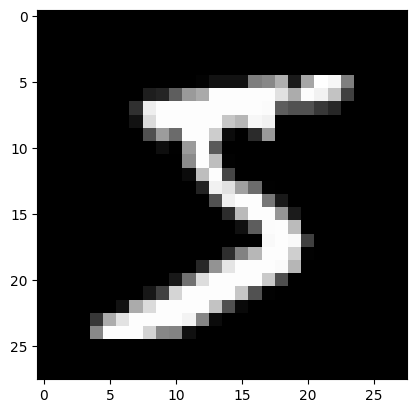

In [17]:
plt.imshow(train_dataset[0][0][0], cmap='gray')

In [159]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 6)
        self.act = nn.LeakyReLU()
        
    def forward(self, x):
        out = x.flatten(1)
        out = self.act(self.fc1(out))
        out = self.act(self.fc2(out))
        out = self.fc3(out)
        return out
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 784)
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        self.act = nn.LeakyReLU()
        
    def forward(self, v):
        out = self.act(self.fc1(v))
        out = self.act(self.fc2(out))
        out = self.act(self.fc3(out))
        out = self.fc4(out).reshape(-1, 1, 28, 28)
        return self.conv(out)
    
class Autoencoder(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
        
    def forward(self, x):
        return self.dec(self.enc(x))

In [160]:
model = Autoencoder(Encoder(), Decoder())

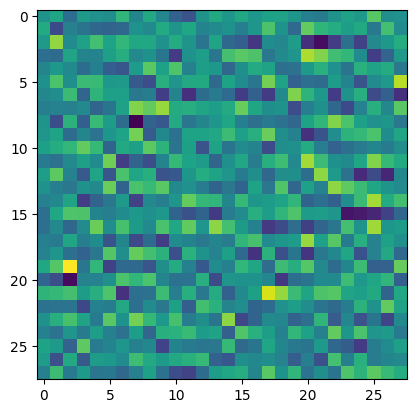

In [161]:
plt.imshow(model(train_dataset[0][0])[0, 0].detach())

In [162]:
model = Autoencoder(Encoder(), Decoder())

  0%|          | 0/20 [00:00<?, ?it/s]

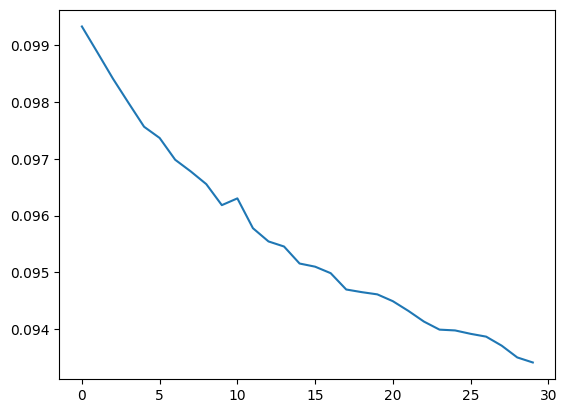

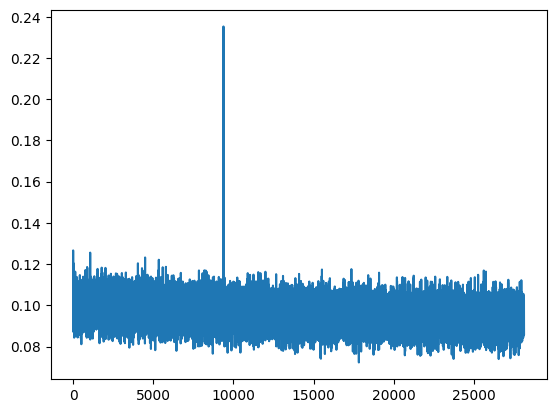

In [178]:
opt = optim.Adam(model.parameters(), lr=4e-3)
crit = nn.MSELoss()

# metrics = []
# losses = []

n_epochs = 20

for ep in trange(n_epochs):
    model.train()
    metric = M.MeanSquaredError()
    for xb, yb in train_loader:
        out = model(xb)
#         print(xb.shape, out.shape, yb.shape)
        loss = crit(out, xb)
        opt.zero_grad()
        loss.backward()
        
        losses.append(loss.item())
        
        metric.update(out, xb)
        
        opt.step()
    metrics.append(metric.compute())
    
plt.plot(metrics)
plt.show()
plt.plot(losses)
plt.show()

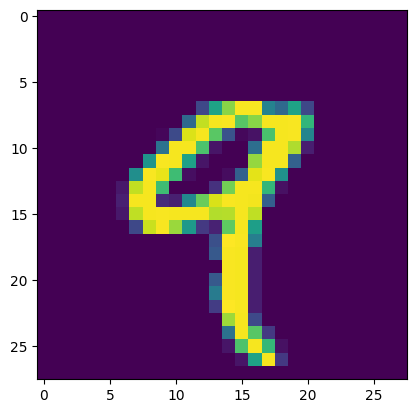

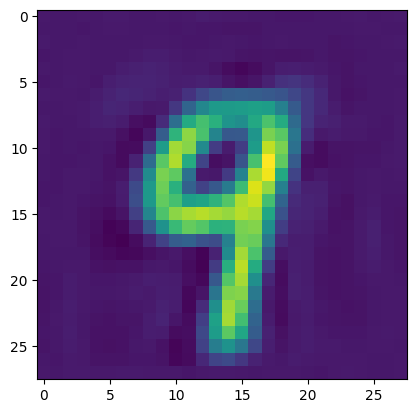

In [179]:
with torch.no_grad():
    plt.imshow(train_dataset[4][0][0])
    plt.show()
    plt.imshow(model(train_dataset[4][0])[0, 0].detach())

In [180]:
with torch.no_grad():
    values = []
    for xb, _ in train_loader:
        out = model.enc(xb)
        values.append(out)
        
values = torch.vstack(values)

In [181]:
values.shape

torch.Size([60000, 6])

In [182]:
values.mean(0)

tensor([ 0.4080, -0.7837, -2.3037,  0.7820,  1.1091,  0.5180])

In [183]:
values.std(0)

tensor([5.0158, 6.7050, 5.6164, 5.6585, 5.0055, 6.4516])

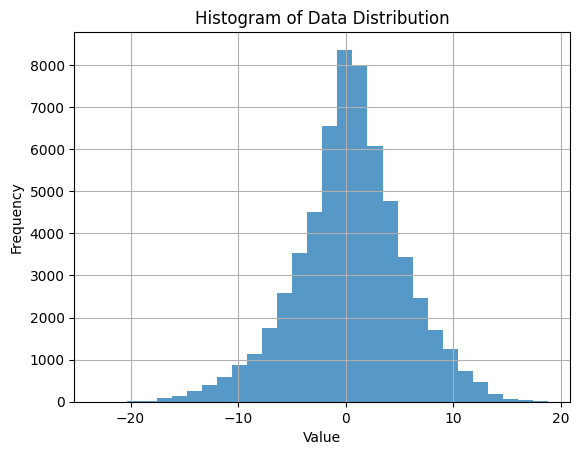

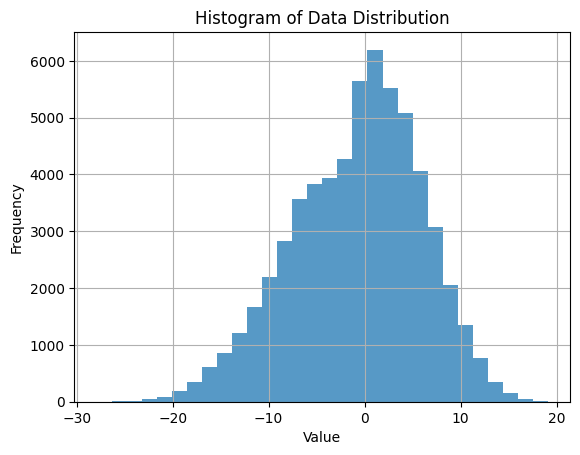

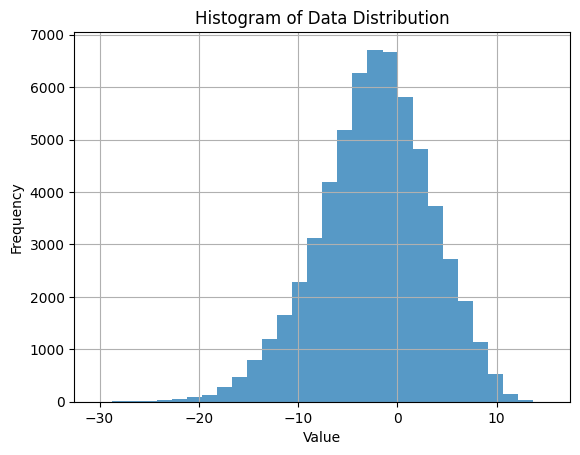

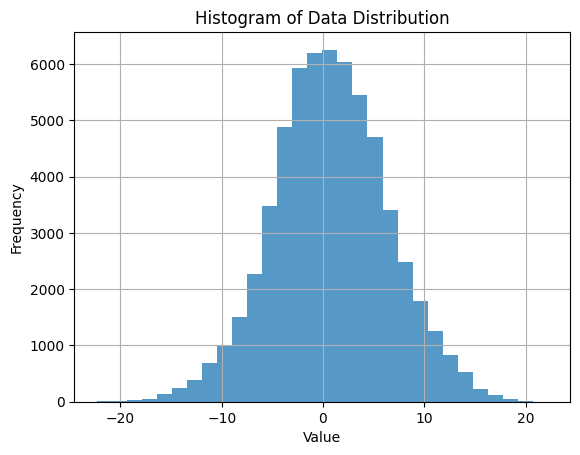

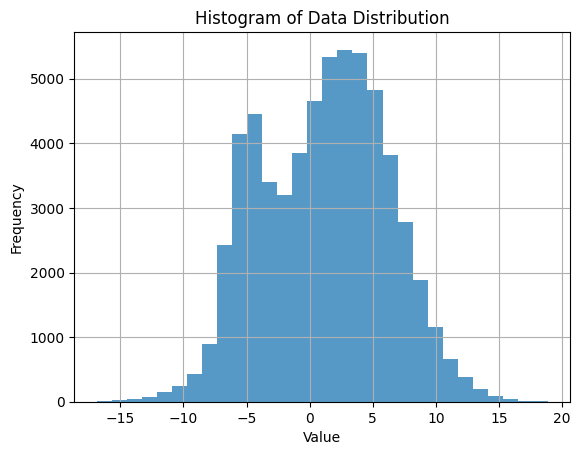

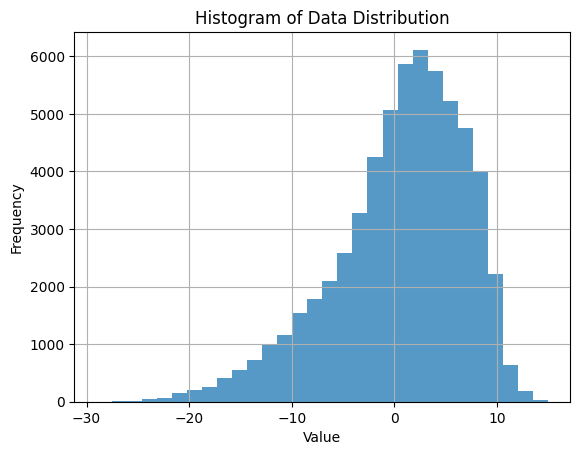

In [184]:
import matplotlib.pyplot as plt

for i in range(6):
    data = values[:, i]
    plt.hist(data, bins=30, alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data Distribution')
    plt.grid(True)
    plt.show()


In [185]:
from random import randint

idx = [randint(0, 59999) for i in range(6)]
vec = values[idx, torch.arange(6)].reshape(1, -1)
vec

tensor([[ 0.6597,  0.0611,  3.0075,  1.4027,  2.6375, -1.1635]])

In [218]:
def random_digit(m, vals):
    idx = [randint(0, 59999) for i in range(vals.shape[1])]
    vec = vals[idx, torch.arange(vals.shape[1])].reshape(1, -1)
    with torch.no_grad():
        pic = model.dec(vec)
    plt.imshow(pic[0, 0].detach(), cmap='gray')
    
    plt.axis('off')
    plt.show()
    return pic

def avg_digit(m, vals):
    vec = vals.mean(dim=0).reshape(1, -1)
    with torch.no_grad():
        pic = model.dec(vec)
    plt.imshow(pic[0, 0].detach(), cmap='gray')
    
    plt.axis('off')
    plt.show()
    return pic

def random_digit_save(m, vals):
    if not hasattr(random_digit_save, 'call_count'):
        setattr(random_digit_save, 'call_count', 0)
    random_digit_save.call_count += 1
    
    idx = [randint(0, 59999) for i in range(vals.shape[1])]
    vec = vals[idx, torch.arange(vals.shape[1])].reshape(1, -1)
    with torch.no_grad():
        pic = model.dec(vec)
    plt.imshow(pic[0, 0].detach(), cmap='gray')
    
    plt.axis('off')
    plt.savefig(f'image_{random_digit_save.call_count:>02}')
    print(f'image_{random_digit_save.call_count:>02}')

image_12


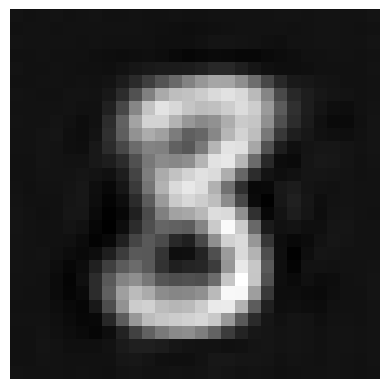

In [230]:
pic = random_digit_save(model, values)

In [202]:
print(f'{2:>02}')

02
